In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Number of records
n = 5000

# Generate CustomerID
customer_id = np.arange(1, n + 1)

age = np.random.normal(40, 12, n).astype(int)
age = np.clip(age, 18, 90)

gender = np.random.choice(['Male', 'Female'], size=n, p=[0.48, 0.52])

# Generate ContractType with extreme imbalance in churn rates
contract_type = np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n, p=[0.7, 0.2, 0.1])

# Generate Tenure with specific patterns based on ContractType
tenure = np.where(contract_type == 'Month-to-month', np.random.randint(1, 3, n),  # 1-2 months
                 np.where(contract_type == 'One year', np.random.randint(12, 24, n),  # 12-24 months
                          np.where(contract_type == 'Two year', np.random.randint(60, 80, n),  # 60-80 months
                                   np.zeros(n))))  # Default to 0 for other cases
tenure += np.random.choice([-1, 0, 1], size=n, p=[0.1, 0.8, 0.1])  # Small seasonal effect
tenure = np.clip(tenure, 0, None)

# Generate MonthlyCharges with higher charges correlated with higher churn
internet_service = np.random.choice(['DSL', 'Fiber optic', 'No'], size=n, p=[0.25, 0.6, 0.15])
monthly_charges = np.where(internet_service == 'DSL', np.random.normal(52, 12, n),
                          np.where(internet_service == 'Fiber optic', np.random.normal(93, 11, n),
                                   np.random.normal(23, 4, n)))

# Generate TechSupport with correlation to InternetService and churn
tech_support = np.where(internet_service == 'No', 'No', np.random.choice(['Yes', 'No'], size=n, p=[0.25, 0.75]))

# Generate PaperlessBilling
paperless_billing = np.random.choice(['Yes', 'No'], size=n, p=[0.75, 0.25])

# Generate PaymentMethod with dependency on PaperlessBilling
payment_method = np.where(paperless_billing == 'Yes', np.random.choice(['Electronic check', 'Credit card (automatic)', 'Bank transfer (automatic)'], size=n, p=[0.6, 0.2, 0.2]), 'Mailed check')

# Calculate Churn Probability and Generate Churn
churn_prob = 0.1 * np.where(gender == 'Female', 0.7, 1.0) * np.where(contract_type == 'Month-to-month', 1.3, np.where(contract_type == 'One year', 0.7, 0.5))
churn_prob = np.clip(churn_prob * np.where(tech_support == 'Yes', 0.6, 1.2) * np.clip(monthly_charges / 100, 1, 2), 0, 1)
churn = np.where(np.random.rand(n) < churn_prob, 'Yes', 'No')

# Generate TotalCharges with strong correlation to MonthlyCharges and Tenure
total_charges = tenure * monthly_charges + np.random.normal(50, 100, n)
total_charges = np.where(tenure < 1, 0, total_charges)

# Assemble into a DataFrame with the required features
df = pd.DataFrame({
    'CustomerID': customer_id,
    'Age': age,
    'Gender': gender,
    'ContractType': contract_type,
    'MonthlyCharges': monthly_charges,
    'TotalCharges': total_charges,
    'TechSupport': tech_support,
    'InternetService': internet_service,
    'Tenure': tenure,
    'PaperlessBilling': paperless_billing,
    'PaymentMethod': payment_method,
    'Churn': churn
})

# Display the first few rows of the dataset
df.head()
df.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        5000 non-null   int64  
 1   Age               5000 non-null   int64  
 2   Gender            5000 non-null   object 
 3   ContractType      5000 non-null   object 
 4   MonthlyCharges    5000 non-null   float64
 5   TotalCharges      5000 non-null   float64
 6   TechSupport       5000 non-null   object 
 7   InternetService   5000 non-null   object 
 8   Tenure            5000 non-null   float64
 9   PaperlessBilling  5000 non-null   object 
 10  PaymentMethod     5000 non-null   object 
 11  Churn             5000 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 468.9+ KB


In [ ]:
df.to_csv('synthetic_customer_data.csv', index=False)


In [ ]:
def countDistinctCategories(categories):
    n = len(categories)
    result = 0

    # Iterate over all subarrays using two pointers (left and right)
    for left in range(n):
        distinct_elements = set()  # To store distinct elements in the current window
        for right in range(left, n):
            distinct_elements.add(categories[right])  # Add current element to the set
            result += len(distinct_elements)  # Add the count of distinct elements in the subarray

    return result

# Input handling
if __name__ == "__main__":
    # First line: number of elements
    n = int(input().strip())
    # Next n lines: the categories
    categories = [int(input().strip()) for _ in range(n)]
    # Output the result
    print(countDistinctCategories(categories))



4
1
5
1
3
18


In [ ]:
!pip install catboost
!pip install ydata-profiling


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve

# Classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Other packages
import os
import pickle
import scipy



In [ ]:
# For CSV, use pandas.read_csv
df = pd.read_csv(r"synthetic_customer_data.csv")
df


,CustomerID,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn
0,1,45,Male,Month-to-month,27.549947,110.425924,No,No,2.0,Yes,Bank transfer (automatic),No
1,2,38,Male,Month-to-month,27.786547,78.123966,No,No,2.0,Yes,Electronic check,No
2,3,47,Male,One year,70.027316,1587.826805,No,Fiber optic,22.0,No,Mailed check,No
3,4,58,Male,Month-to-month,99.034855,218.686033,Yes,Fiber optic,2.0,No,Mailed check,No
4,5,37,Male,Month-to-month,45.566193,-39.397974,No,DSL,1.0,Yes,Electronic check,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,39,Male,Month-to-month,89.996262,191.129879,No,Fiber optic,1.0,No,Mailed check,No
4996,4997,48,Female,One year,79.926118,1398.424566,No,Fiber optic,17.0,Yes,Electronic check,No
4997,4998,77,Female,Two year,25.723352,1833.510062,No,No,65.0,Yes,Electronic check,No
4998,4999,49,Male,Month-to-month,78.164757,166.154675,Yes,Fiber optic,1.0,Yes,Credit card (automatic),Yes


In [ ]:
import pandas_profiling as pp
# Use pandas_profiling.ProfileReport method
pp.ProfileReport(df)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
if 'CustomerID' in df.columns:
    df = df.drop(['CustomerID'], axis=1)



NameError: name 'df' is not defined

On deep analysis, we can find some indirect missingness in our data (which can be in form of blankspaces). Let's see that!

In [ ]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

,0
Age,0
Gender,0
ContractType,0
MonthlyCharges,0
TotalCharges,0
TechSupport,0
InternetService,0
Tenure,0
PaperlessBilling,0
PaymentMethod,0


In [ ]:

# Average Monthly Charges: Total Charges divided by Tenure
average_monthly_charges = df['TotalCharges'] / np.where(df['Tenure'] > 0, df['Tenure'], 1)
average_monthly_charges = average_monthly_charges.replace([np.inf, -np.inf], np.nan)  # Replace any infinite values with NaN

# Customer Lifetime Value: Tenure multiplied by Monthly Charges
customer_lifetime_value = df['Tenure'] * df['MonthlyCharges']

# Add the derived features to the DataFrame
df['AverageMonthlyCharges'] = average_monthly_charges
df['CustomerLifetimeValue'] = customer_lifetime_value

# Display the first few rows of the dataset with derived features
df.head()


,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,AverageMonthlyCharges,CustomerLifetimeValue
0,45,Male,Month-to-month,27.549947,110.425924,No,No,2.0,Yes,Bank transfer (automatic),No,55.212962,55.099894
1,38,Male,Month-to-month,27.786547,78.123966,No,No,2.0,Yes,Electronic check,No,39.061983,55.573095
2,47,Male,One year,70.027316,1587.826805,No,Fiber optic,22.0,No,Mailed check,No,72.173946,1540.600941
3,58,Male,Month-to-month,99.034855,218.686033,Yes,Fiber optic,2.0,No,Mailed check,No,109.343016,198.069710
4,37,Male,Month-to-month,45.566193,-39.397974,No,DSL,1.0,Yes,Electronic check,Yes,-39.397974,45.566193


Here we see that the TotalCharges has 496 missing values and AverageMonthlyCharges have 542 missing values. Let's check this data.

In [ ]:
df[np.isnan(df['TotalCharges'])]
df[np.isnan(df['AverageMonthlyCharges'])]



,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,AverageMonthlyCharges,CustomerLifetimeValue


In [ ]:
df[df['Tenure'] == 0].index


Index([  19,   27,   71,   79,  155,  214,  227,  232,  257,  280,
       ...
       4734, 4849, 4862, 4877, 4878, 4879, 4888, 4904, 4960, 4977],
      dtype='int64', length=185)

In [ ]:
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df)
df_dummies.head()

,Age,MonthlyCharges,TotalCharges,Tenure,Churn,AverageMonthlyCharges,CustomerLifetimeValue,Gender_Female,Gender_Male,ContractType_Month-to-month,...,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,45,27.549947,110.425924,2.0,0,55.212962,55.099894,False,True,True,...,False,False,False,True,False,True,True,False,False,False
1,38,27.786547,78.123966,2.0,0,39.061983,55.573095,False,True,True,...,False,False,False,True,False,True,False,False,True,False
2,47,70.027316,1587.826805,22.0,0,72.173946,1540.600941,False,True,False,...,False,False,True,False,True,False,False,False,False,True
3,58,99.034855,218.686033,2.0,0,109.343016,198.069710,False,True,True,...,True,False,True,False,True,False,False,False,False,True
4,37,45.566193,-39.397974,1.0,1,-39.397974,45.566193,False,True,True,...,False,True,False,False,False,True,False,False,True,False


There are no additional missing values in the Tenure column.


<Axes: >

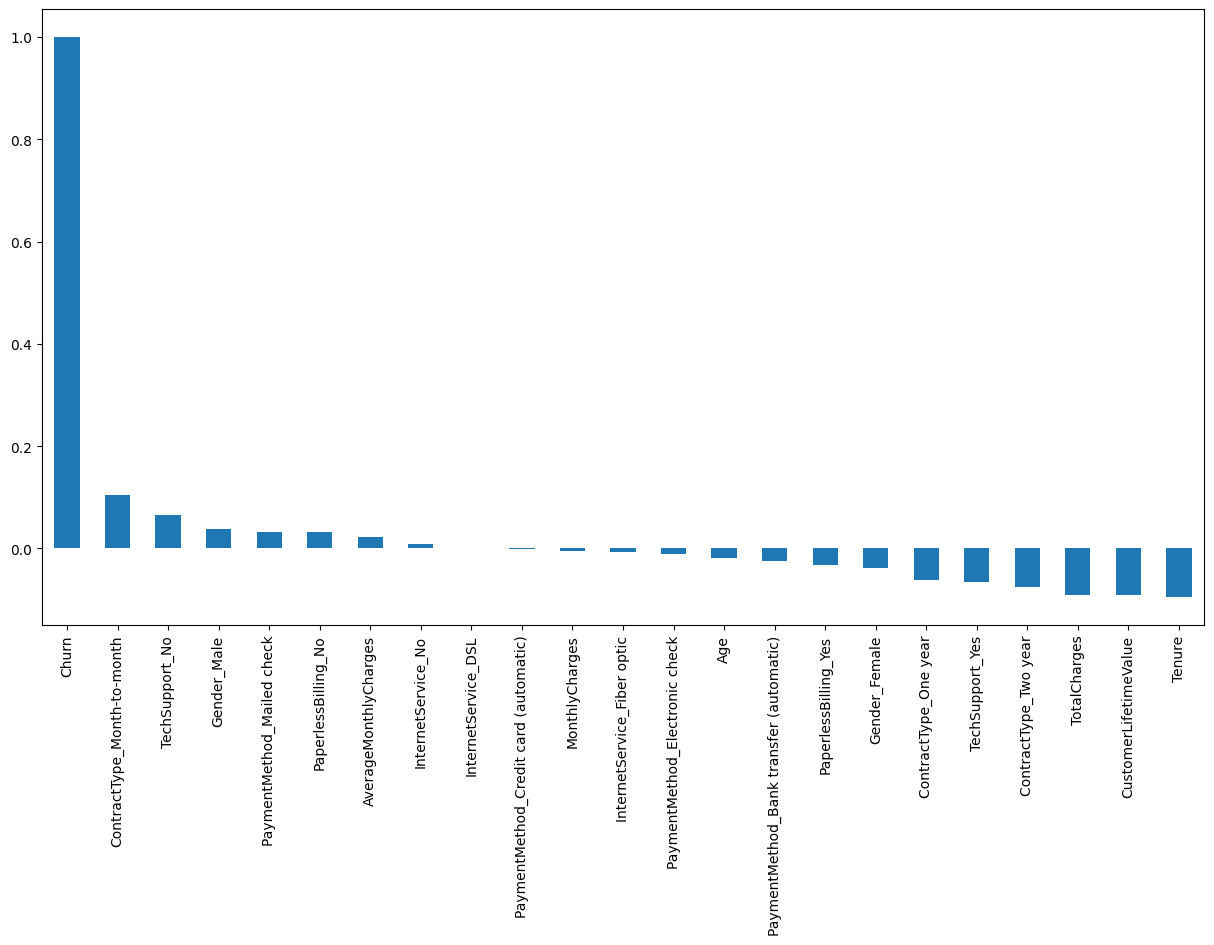

In [ ]:
#Get Correlation of "Churn" with other variables
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Month-to-month contracts show the second highest positive correlation, suggesting that customers with shorter-term commitments are more likely to churn.
Lack of tech support and internet service also show positive correlations with churn, indicating that customers without these services may be more prone to leaving.
On the negative side of the correlation:
Two-year contracts also have a notable negative correlation, suggesting that longer contract commitments reduce churn.
TotalCharges and MonthlyCharges both show negative correlations, which might indicate that customers who spend more are less likely to churn, possibly due to greater engagement with services.
Several services like Fiber optic internet, online security, and streaming TV show very slight negative correlations. This could suggest that customers with these additional services are marginally less likely to churn, but the effect appears to be minimal based on the chart.


Gender Distribution - About half of the customers in our data set are male while the other half are female

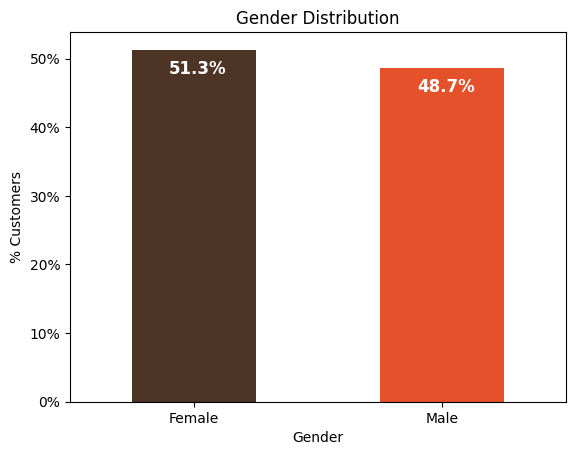

In [ ]:
import matplotlib.ticker as mtick
colors = ['#4D3425','#E4512B']
ax = (df['Gender'].value_counts()*100.0 /len(df)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

B.) Customer Account Information: Let u now look at the tenure, contract

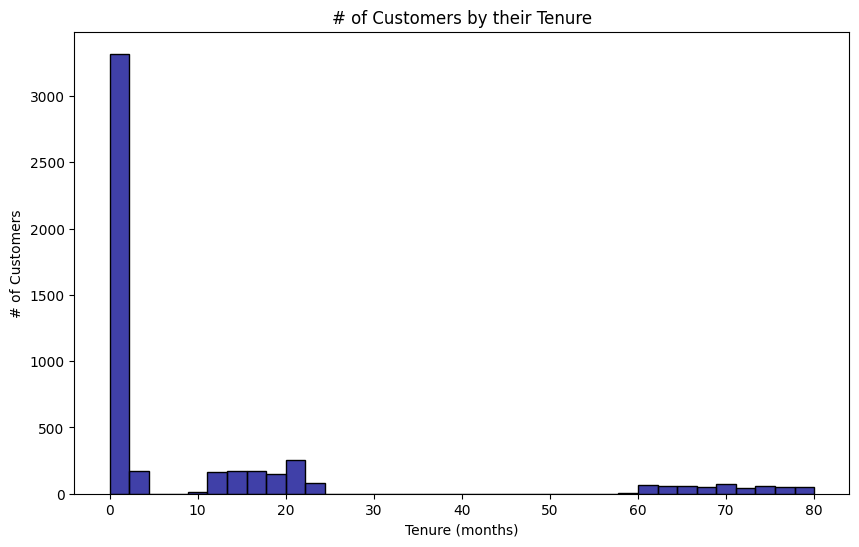

In [ ]:

# Plot the distribution of the 'Tenure' column
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

ax = sns.histplot(df['Tenure'],
                  bins=int(180/5),
                  color='darkblue',
                  edgecolor='black',
                  kde=False)

# Customize the plot
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their Tenure')

# Show the plot
plt.show()


2. Contracts: To understand the above graph, lets first look at the # of customers by different contracts.



Text(0.5, 1.0, '# of Customers by Contract Type')

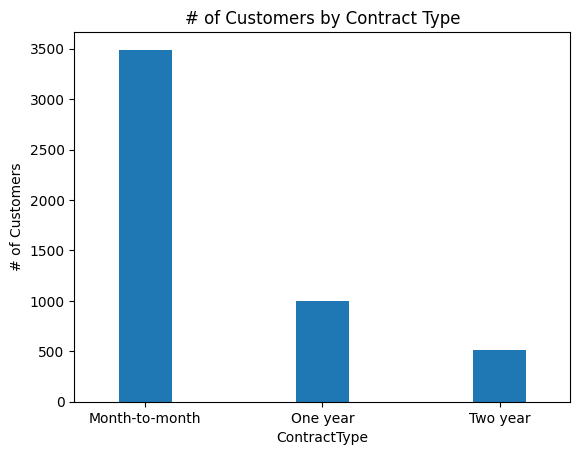

In [ ]:
ax = df['ContractType'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')


As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.

Below we will understand the tenure of customers based on their contract type.



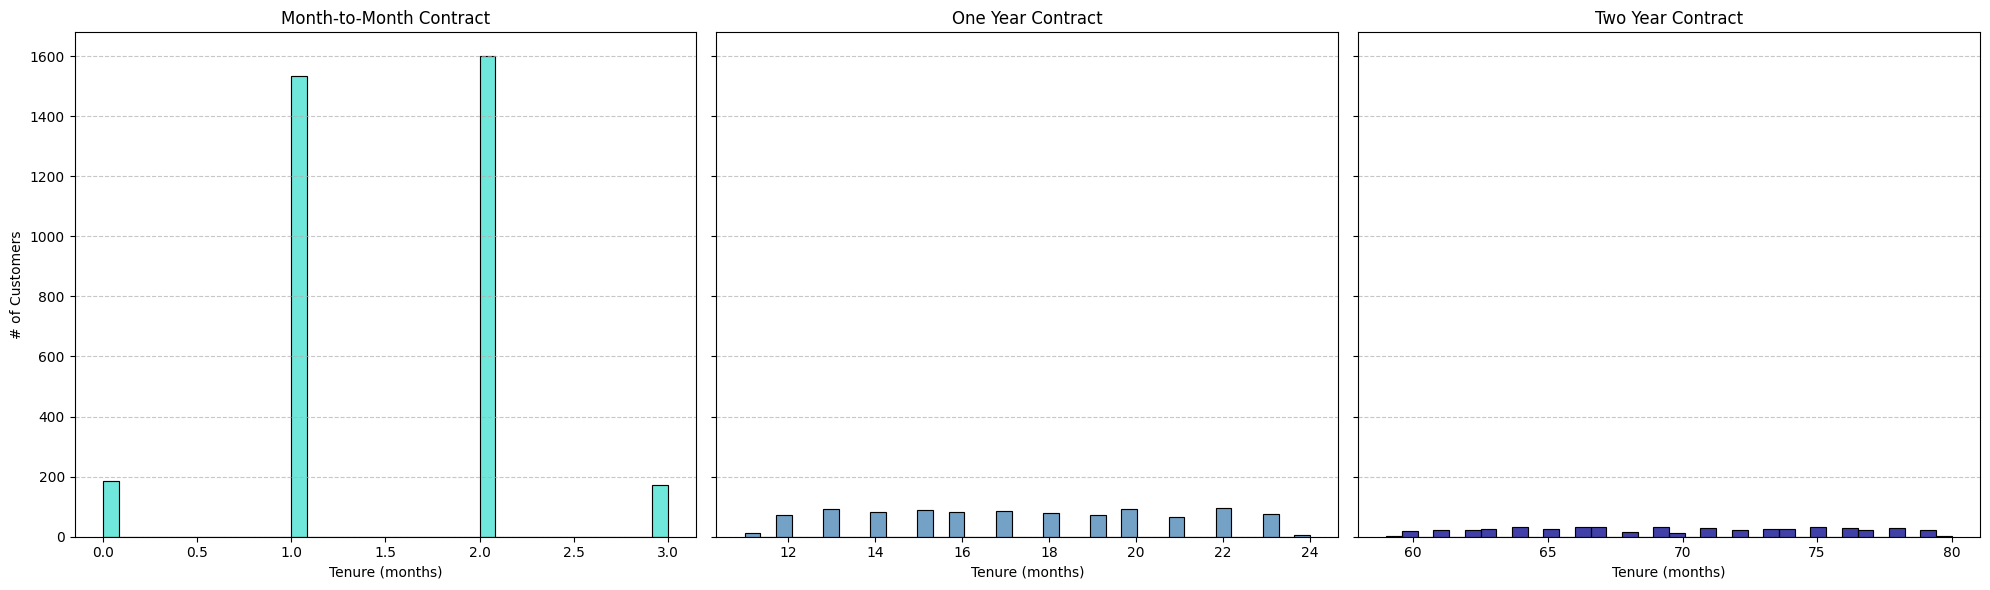

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 6))

# Plot for Month-to-month Contract
sns.histplot(df[df['ContractType'] == 'Month-to-month']['Tenure'],
             bins=int(180 / 5), color='turquoise', edgecolor='black', ax=ax1)
ax1.set_ylabel('# of Customers')
ax1.set_xlabel('Tenure (months)')
ax1.set_title('Month-to-Month Contract')
ax1.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

# Plot for One Year Contract
sns.histplot(df[df['ContractType'] == 'One year']['Tenure'],
             bins=int(180 / 5), color='steelblue', edgecolor='black', ax=ax2)
ax2.set_xlabel('Tenure (months)')
ax2.set_title('One Year Contract')
ax2.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

# Plot for Two Year Contract
sns.histplot(df[df['ContractType'] == 'Two year']['Tenure'],
             bins=int(180 / 5), color='darkblue', edgecolor='black', ax=ax3)
ax3.set_xlabel('Tenure (months)')
ax3.set_title('Two Year Contract')
ax3.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

# Show the plots
plt.tight_layout()
plt.show()


C. Let us now look at the distribution of various services used by customers¶


In [ ]:
df.columns.values


array(['Age', 'Gender', 'ContractType', 'MonthlyCharges', 'TotalCharges',
       'TechSupport', 'InternetService', 'Tenure', 'PaperlessBilling',
       'PaymentMethod', 'Churn', 'AverageMonthlyCharges',
       'CustomerLifetimeValue'], dtype=object)

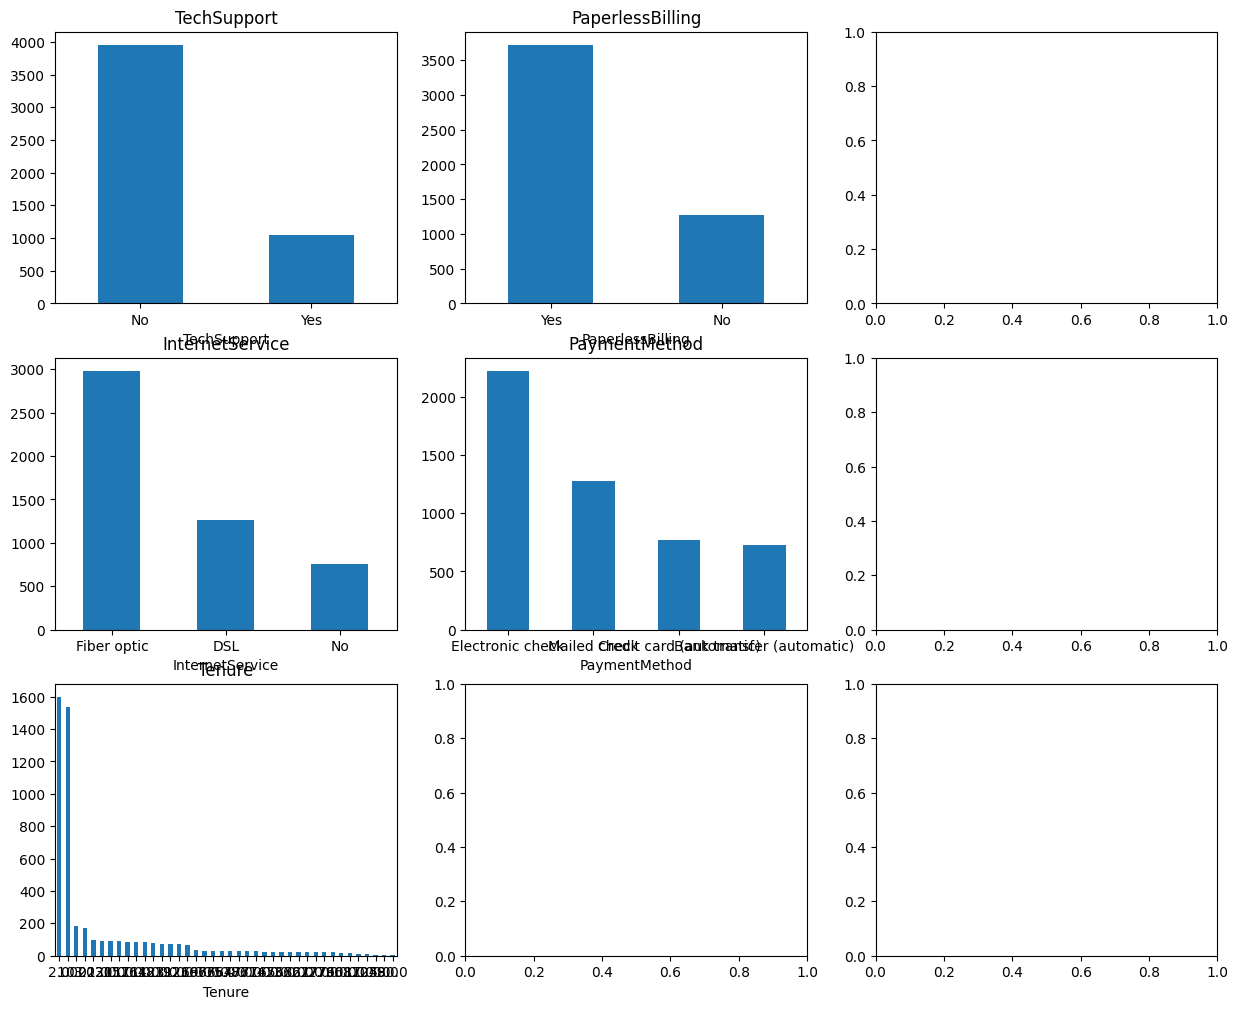

In [ ]:
import matplotlib.pyplot as plt

services = ['TechSupport', 'InternetService', 'Tenure', 'PaperlessBilling',
       'PaymentMethod']
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))


for i, item in enumerate(services):
    if i < 3:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)

    elif i >=3 and i < 6:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)

    elif i < 9:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

 Now let's take a quick look at the relation between monthly and total charges

<Axes: xlabel='MonthlyCharges', ylabel='TotalCharges'>

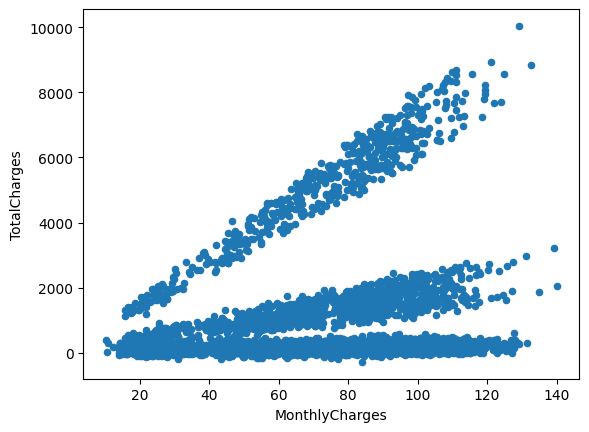

In [ ]:
df[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                              y='TotalCharges')

E.) Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot.¶

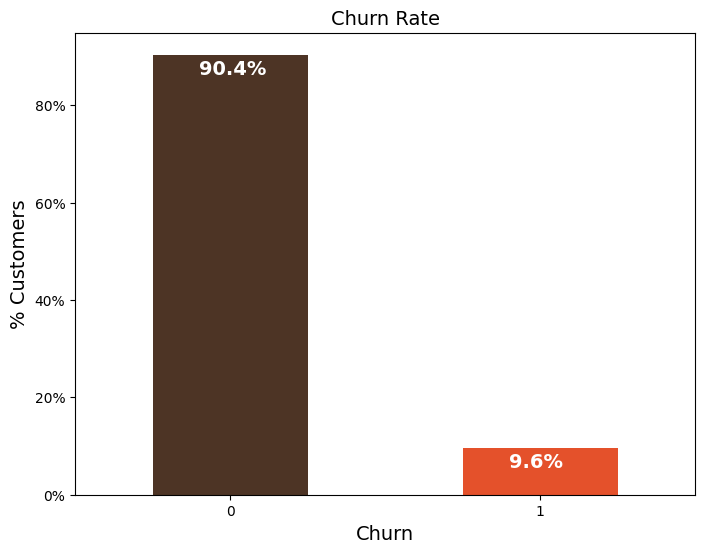

In [ ]:

# Colors for the bars
colors = ['#4D3425', '#E4512B']
ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
# Plotting the churn rate as a percentage
color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            color='white',
           weight = 'bold',
           size = 14)



i.) Churn vs Tenure: As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.



<Axes: xlabel='Churn', ylabel='Tenure'>

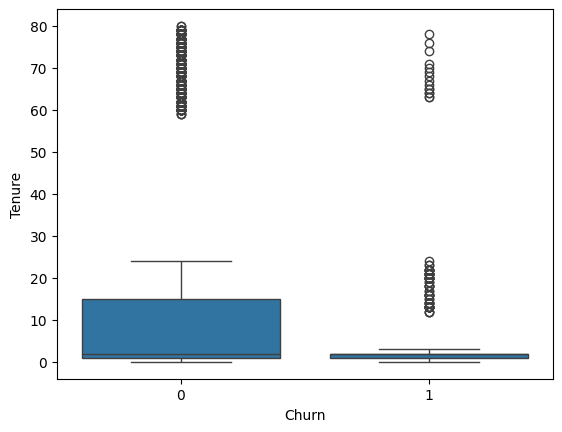

In [ ]:
sns.boxplot(x = df.Churn, y = df.Tenure)


ii.) Churn by Contract Type: Similar to what we saw in the correlation plot, the customers who have a month to month contract have a very high churn rate.

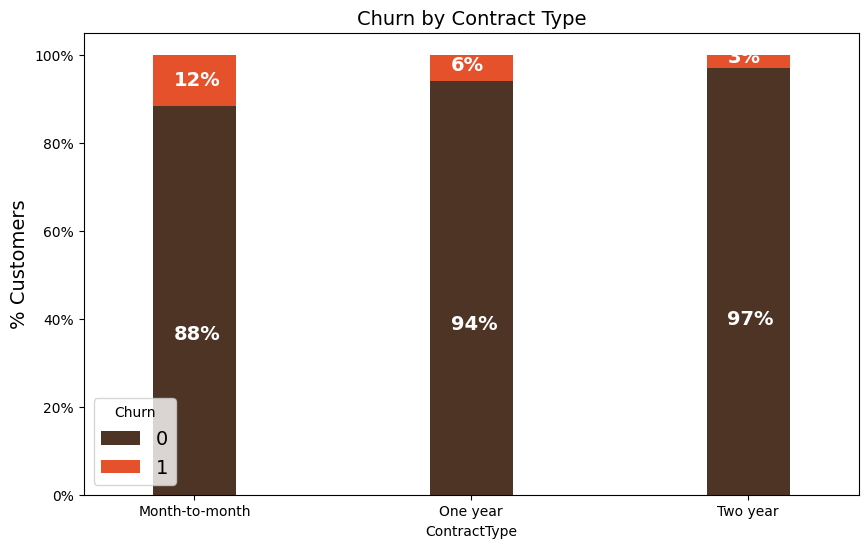

In [ ]:
colors = ['#4D3425','#E4512B']
contract_churn = df.groupby(['ContractType','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0,
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

After going through the above EDA we will develop some predictive models and compare them.
We will develop Logistic Regression, Random Forest, SVM, ADA Boost and XG Boost
1. Logistic Regression





In [ ]:
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [ ]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)
from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))


0.9186666666666666


Axes(0.125,0.11;0.775x0.77)


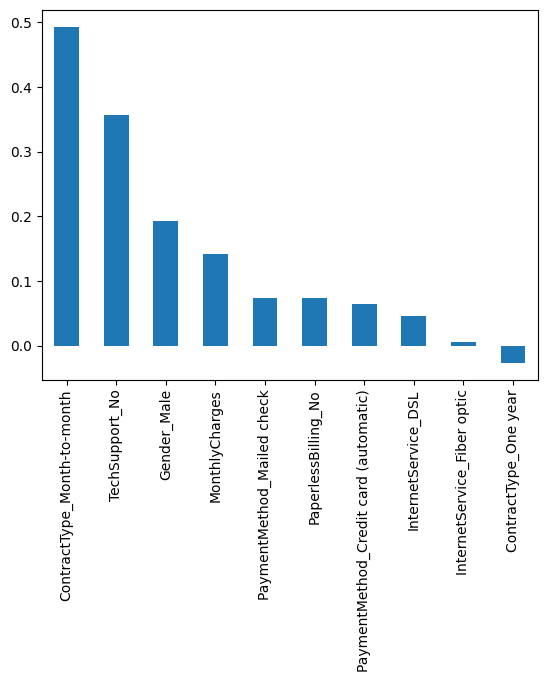

In [ ]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

Axes(0.125,0.11;0.775x0.77)


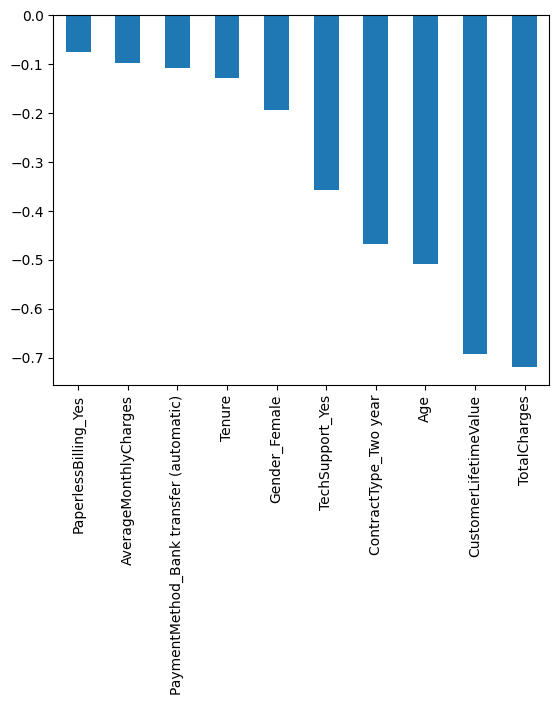

In [ ]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))


Observations

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable.

2. Random Forest



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Initialize and train the Random Forest model with corrected parameters
model_rf = RandomForestClassifier(
    n_estimators=1000,
    oob_score=True,
    n_jobs=-1,
    random_state=50,
    max_features='sqrt',
    max_leaf_nodes=30
)

# Fit the model
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

# Print accuracy score
print(metrics.accuracy_score(y_test, prediction_test))



0.92


<Axes: >

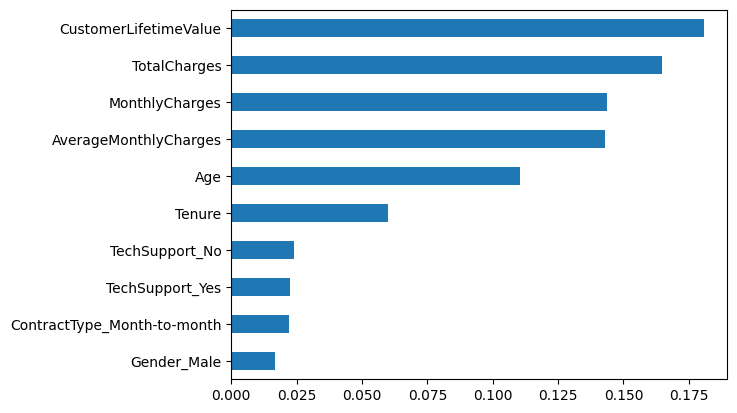

In [ ]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

3. Support Vecor Machine (SVM)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
from sklearn.svm import SVC

model.svm = SVC(kernel='linear')
model.svm.fit(X_train,y_train)
preds = model.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)



0.91

In [ ]:

# Create the Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,preds))

[[910   0]
 [ 90   0]]


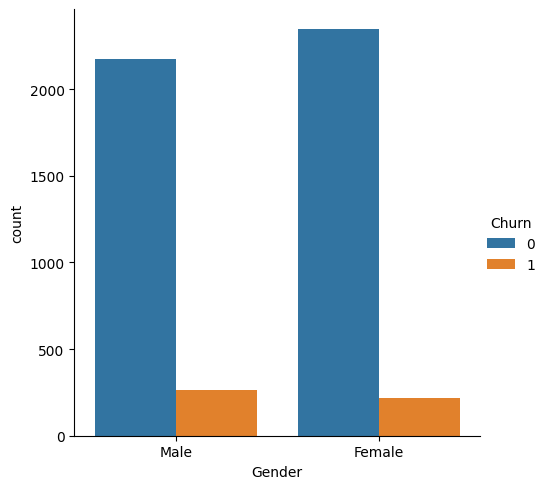

In [ ]:
ax1 = sns.catplot(x="Gender", kind="count", hue="Churn", data=df,
                  estimator=lambda x: sum(x==0)*100.0/len(x))
#ax1.yaxis.set_major_formatter(mtick.PercentFormatter())


4. XG Boost



In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)


0.895

5.  ADA Boost

In [ ]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
# n_estimators = 50 (default value)
# base_estimator = DecisionTreeClassifier (default value)
model.fit(X_train,y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)


0.909